## Problem formulation

We imagine a regression problem in $D$ dimensions with inputs $\mathbf{x}_i \in \mathbb{R}^{D}$ and one-dimensional outputs $y_i \in \mathbb{R}$ on the form of

$$ y_i = f(\mathbf{x}_i) + \epsilon(\mathbf{x}_i) $$

where $\epsilon(\mathbf{x}_i) = \mathcal{N}(0,\sigma_{\epsilon}^2(\mathbf{x}_i))$ is a noise term. If the variance $\sigma^2(\mathbf{x}_i) = \sigma^2_{\epsilon}$ is constant w.r.t. $\mathbf{x}$ it is called *homoscedastic* noise and *heteroscedastic* if not. 



Our goal is to learn a probabilistic regression model $p_{\theta}(y|\mathbf{x})$, which for now we will assume is a normal distribution:

$$p_{\theta}(y|\mathbf{x}) = \mathcal{N}(y|\mu(\mathbf{x}),\sigma_p^2(\mathbf{x}))$$

such as the case for Gaussian Processes (GPs) with predictive variance $\sigma_p^2(\mathbf{x})$. We want the model not only to have a good prediction error (e.g. a low mean squared error) but also has well-calibrated uncertainties $\sigma_p^2(\mathbf{x})$. We shall assume, the predictive variance has a (either analytical or approximal)  decomposition:

$$\sigma_p^2(\mathbf{x}) = \sigma_e^2(\mathbf{x}) + \sigma_a^2(\mathbf{x})$$

where $\sigma_a^2(\mathbf{x})$ is the *aleatoric* noise (irreducible inherent randomness in the data-generating process) and $\sigma_e^2(\mathbf{x})$ is the *epidemestic* noise (lack of knowledge, i.e. it can be reduced with better models or more data). Although the predictive variance from the GP has this exact explicit decomposition: 
$$\sigma_p^2(\mathbf{x})=\underbrace{K(\mathbf{x}_*,\mathbf{x}_*)-K(\mathbf{x}_*,\mathbf{X})(K(\mathbf{X},\mathbf{X})+\sigma_nI)^{-1}K(\mathbf{X},\mathbf{x}_*)}_{\sigma^2_e} + \underbrace{\sigma_n^2I}_{\sigma^2_a}$$

and we are guarenteed that $\sigma_n^2 \xrightarrow{} \sigma_{\epsilon}^2$ in the limit of infinite samples, no such guarentee exists for finite samples and GPs are one of the few models to have this explicit decomposition. However, in this paper we argue that if a regressor has an explicit bias-variance decomposition we can at least approximate both aleatoric and epidemistic noise terms. 

### Bias-variance decomposition
An often used loss function for regression models is the mean-squared-error (MSE) loss. With a model producing a prediction $\hat{y}$ the expectation of MSE between $\hat{y}$ and the observed $y$ can be decomposed (for brevity we have left out the dependence on input $\mathbf{x}$):
\begin{split}
\mathbb{E}[(y-\hat{y})^2] &= E[(f+\epsilon-\hat{y})^2] \\
&= E[(f-\hat{y})^2+2(f-\hat{y})\epsilon+\epsilon^2]\\
&= E[(f-\hat{y})^2]+2E[(f-\hat{y})\epsilon]+E[\epsilon^2]\\
&= E\left[\left(f - E(\hat{y}) + E(\hat{y})-\hat{y} \right)^2 \right] + 2E[(f-\hat{y})\epsilon]+\sigma_{\epsilon}^2 \\
& = Var(\hat{y}) + \text{Bias}^2(\hat{y}) + \sigma_{\epsilon}^2.
\end{split}



### Calibration


### $\mathcal{C}_y$ vs. $\mathcal{C}_f$

In a real-world application scenario, we could imagine having access to one or more of the following properties of the system of interest:

- Have access to or being able to repeat the experiment for the same input $\mathbf{x}_i$
- Have knowledge of the true underlying function $f(\mathbf{x}_i)$ for certain ranges of $\mathbf{x}_i$
- Have knowledge of $\sigma_{\epsilon}^2(\mathbf{x}_i)$ for certain ranges of $\mathbf{x}_i$
- Have an estimate of $|y_i - f(\mathbf{x}_i)|$ for certain ranges of $\mathbf{x}_i$

The first scenario is realistic in areas such as bayesian optimization, active learning and reinforcement learning. The second and third points might not be realistic many real-world problems, but given the first principle, we could estimate both $f(\mathbf{x}_i)$ and $\sigma^2_{\epsilon}(\mathbf{x}_i)$ by averaging over experiments with same input. Furthermore, if the noise is homoscedastic, on such repeatable experiment will result in an estimation of $\sigma^2_{\epsilon}$. If the noise is heteroscedastic and depending on the application, it might be possible or perhaps sufficient to interpolate the additive noise between training points. Lastly, we can imagine applications where we have a "realiability"-measure for each datapoint. 


|                   | $\sigma_p$ | $\sigma_e$ 
| ---               | ---           | --- 
| $\mathcal{C}_y$   |   Kuleshov | X
| $\mathcal{C}_f$   | Our work | Our  work



### Algorithm
1. Get data with $n$ training samples
2. Train probabilistic regressor 
3. Get $L$ best points $\mathbf{x}_{l}$ by acquisition function 
4. Make $K$ experiments at each point $\mathbf{x}_{l}$ given to obtain estimate $\hat{f}_l(\mathbf{x}_{l}) = \frac{1}{K} \sum y(\mathbf{x}_{l}) $
5. Update estimate on aleatoric noise $\sigma^2_{\epsilon}$
6. With leave-one-out cross-validation to obtain $n$ regressors
7. Make correction: $\sigma^2_{e_{n+1}} = \text{argmin}_{\sigma^2} \frac{1}{K} \sum CCIP$

In [10]:
from imports.ml import *
from imports.general import *
from src.calibration import Calibration
from src.parameters import Parameters
from surrogates.random_forest import RandomForest

In [11]:
def make_dataset(seed:int=0,n_train:int=10,sigma_data:float = 1e-1):
    np.random.seed(seed)
    n = 1000
    x = np.linspace(0,1,n)
    f = np.sin(2*x)
    y = f + np.random.normal(0,sigma_data,size=f.shape)
    return x,f,y,train_test_split(x, y, shuffle=True, train_size=n_train/n, random_state=42)


In [25]:
def fit_gp(seed:int=0,sigma_initial:float = None):
    np.random.seed(seed)
    rbf_kernel = 1.0 * RBF(length_scale_bounds=(1e-5, 1e3))
    if sigma_initial is not None:
        noise_kernel = WhiteKernel(noise_level=sigma_data**2,noise_level_bounds="fixed") 
    else:
        noise_kernel = WhiteKernel(noise_level_bounds=(1e-10, 1e1)) 
    kernel = rbf_kernel + noise_kernel
    model = GaussianProcessRegressor(kernel=kernel).fit(x_train[:,np.newaxis],y_train)
    y_pred,sigma_p = model.predict(x[:,np.newaxis],return_std=True)
    if sigma_initial is not None:
        sigma_a = np.full(sigma_p.shape,sigma_initial)
    else:
        sigma_a = np.full(sigma_p.shape,np.sqrt(np.exp(model.kernel_.theta[-1])))
    sigma_e = np.sqrt(sigma_p**2-sigma_a**2)
    bias = np.mean((f-y_pred)**2)
    # print(model.kernel_)
    # print(model.kernel_.theta)
    # print(np.exp(model.kernel_.theta[-1]))
    # print(np.mean(sigma_a))
    # print(np.mean(sigma_p))
    return sigma_p,sigma_a,sigma_e,bias,y_pred

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def fit_rf(seed:int=0,sigma_a:float = None):
    np.random.seed(seed)
    model = RandomForest()
    model.fit(x_train[:,np.newaxis],y_train)
    y_pred,sigma_p = model.predict(x[:,np.newaxis])
    # if sigma_a is not None:
    #     sigma_a = None
    
    sigma_e = sigma_p**2 - sigma_a**2
    bias = np.mean((f-y_pred)**2)
    return sigma_p,sigma_a,sigma_e,bias,y_pred

class RandomForest(object):
    """Random forest surrogate class. """

    def __init__(
        self
    ):
        self.set_hyperparameter_space()

    def set_hyperparameter_space(self):
        self.rf_params_grid = {
            "n_estimators": [10, 100, 1000],
            "max_depth": [5, 10, 20],
            # "max_samples": [int(self.n_initial / 2), int(self.n_initial)],
            "max_features": ["auto", "sqrt"],
        }

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        grid_search = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid=self.rf_params_grid,
            cv=5,
            n_jobs=-1,
            verbose=0,
        ).fit(X_train, y_train.squeeze())
        self.model = grid_search.best_estimator_

    def predict(
        self, X_test: np.ndarray, stabilizer: float = 1e-8
    ) -> Tuple[np.ndarray, np.ndarray]:
        mu_predictive = self.model.predict(X_test)
        sigma_predictive = self.calculate_y_std(X_test) + stabilizer
        return mu_predictive, sigma_predictive

    def calculate_y_std(self, X: np.ndarray) -> np.ndarray:
        predictions = self.tree_predictions(X)
        sigma_predictive = np.nanstd(predictions, axis=0)
        return sigma_predictive

    def tree_predictions(self, X: np.ndarray) -> np.ndarray:
        predictions = np.full((len(self.model.estimators_), X.shape[0]), np.nan)
        for i_e, estimator in enumerate(self.model.estimators_):
            predictions[i_e, :] = estimator.predict(X)
        return predictions


In [13]:
def plot_predictive(save:bool=False):
    if np.mean(sigma_a) > np.mean(sigma_e):
        alpha_a,alpha_e = 0.1,0.2
    else:
        alpha_e,alpha_a = 0.1,0.2

    fig = plt.figure(figsize=(10,5))
    plt.plot(x,f,color="black",label="f")
    plt.plot(x_train,y_train,".",color="black",label="train",alpha=0.6)
    plt.plot(x_test,y_test,".",color="green",label="test",alpha=0.1)
    plt.plot(x,y_pred,color="blue",label="Prediction")
    plt.fill_between(
        x,
        f,
        y_pred,
        color="red",
        alpha=0.5,
        label="Bias",
    )
    # plt.fill_between(
    #     x,
    #     y_pred - sigma_a,
    #     y_pred + sigma_a,
    #     facecolor="none",
    #     alpha=alpha_a,
    #     hatch="X", 
    #     linewidth=0.0,
    #     edgecolor="blue", 
    # )
    plt.plot(
        x,
        y_pred - sigma_a,
        "--",
        color="blue",
        label=r"$\sigma_a$" + " (noise)",
    )
    plt.plot(
        x,
        y_pred + sigma_a,
        "--",
        color="blue",
    )
    plt.fill_between(
        x,
        y_pred - sigma_e,
        y_pred + sigma_e,
        color="blue",
        alpha=alpha_e,
        label=r"$\sigma_e$" + " (variance)",
    )
    plt.fill_between(
        x,
        y_pred - sigma_p,
        y_pred + sigma_p,
        color="blue",
        alpha=0.05,
        label=r"$\sigma_p$",
    )
    
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylim([0.0,1.2])
    # plt.xlim([0.2,1.0])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    if save:
        fig.savefig(f"visualizations/figures/predictive-example.pdf")
    plt.show()

def plot_calibration(summary:Dict,save:bool=False):
    fig = plt.figure(figsize=(10,5))
    plt.plot(summary["y_p_array"],summary["y_p_array"],"--")
    plt.plot(summary["y_p_array"],summary["y_calibration"],"--o",label=r"$\mathcal{C}_y$ "+f"(error={summary['y_calibration_mse']:.2E})",color="blue")
    plt.plot(summary["f_p_array"],summary["f_calibration"],"--o",label=r"$\mathcal{C}_f$ "+f"(error={summary['f_calibration_mse']:.2E})",color="black")
    plt.xlabel("Expected Confidence Level")
    plt.ylabel("Observed Confidence Level")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    if save:
        fig.savefig(f"visualizations/figures/calibration-example.pdf")
    plt.show()

In [26]:
sigma_data=1e-1
x,f,y,(x_train, x_test, y_train, y_test) = make_dataset(seed=1,n_train=10,sigma_data=sigma_data)
# sigma_p,sigma_a,sigma_e,bias,y_pred = fit_gp(seed=0,sigma_initial=sigma_data)
sigma_p,sigma_a,sigma_e,bias,y_pred = fit_rf(seed=0,sigma_a=sigma_data)
# print("Model bias",bias)
# print("Model std",np.mean(sigma_e))
# print("Predictive std",np.mean(sigma_p))
# print("Estimated noise std",np.mean(sigma_a))
# print("True noise std",sigma_data)
parameters = Parameters()
calibration = Calibration(parameters)

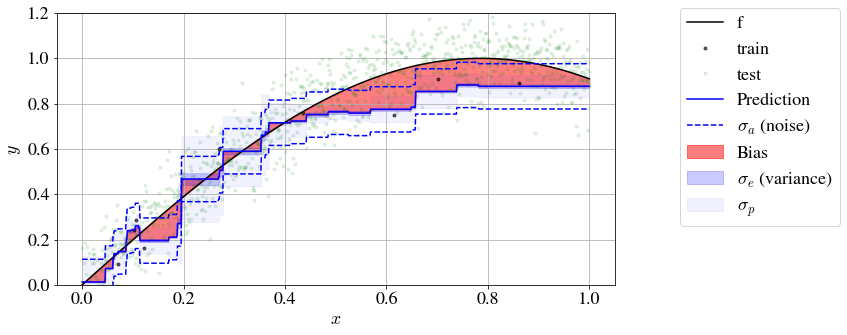

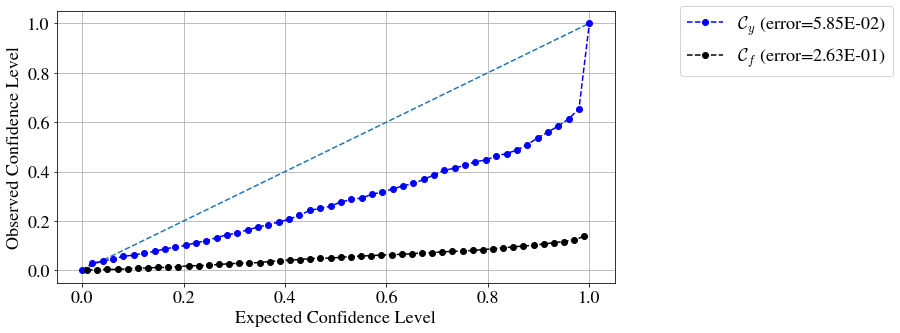

In [27]:
calibration.calibration_global(y_pred,sigma_p,y)
calibration.check_f_calibration(y_pred,sigma_e,f)
plot_predictive(save=True)
plot_calibration(calibration.summary,save=True)

#### Learn recalibration

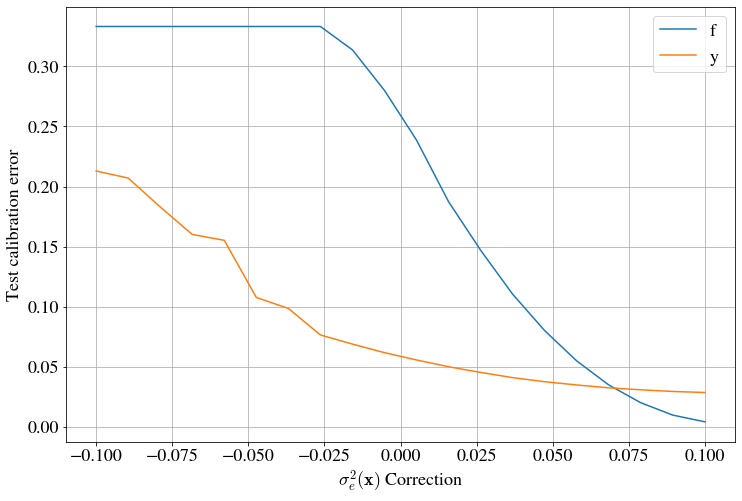

In [28]:
y_mses = []
f_mses = []
correction_array = np.linspace(-0.1,0.1,20)
for correction in correction_array:
    sigma_e_ = sigma_e + correction
    calibration.check_f_calibration(y_pred,sigma_e_,f)
    f_mses.append(calibration.summary["f_calibration_mse"])

    sigma_p_ = sigma_p + correction
    calibration.calibration_global(y_pred,sigma_p_,y)
    y_mses.append(calibration.summary["y_calibration_mse"])

plt.plot(correction_array,f_mses,label="f")
plt.plot(correction_array,y_mses,label="y")
plt.xlabel(r"$\sigma^2_e(\mathbf{x})$ Correction")
plt.ylabel("Test calibration error")
plt.legend()

In [29]:
sigma_e = sigma_e + correction_array[np.argmin(f_mses)]
sigma_p = sigma_p + correction_array[np.argmin(y_mses)]

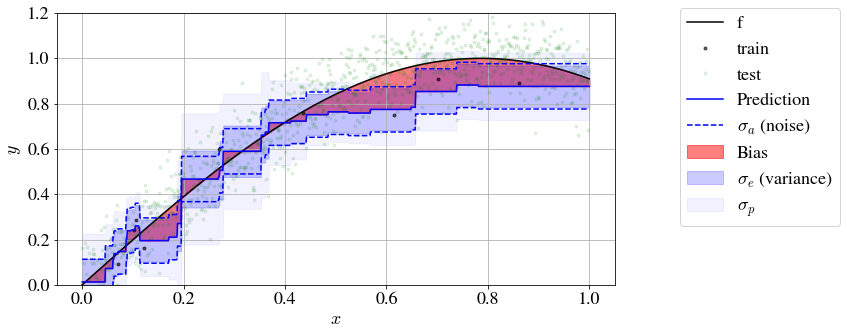

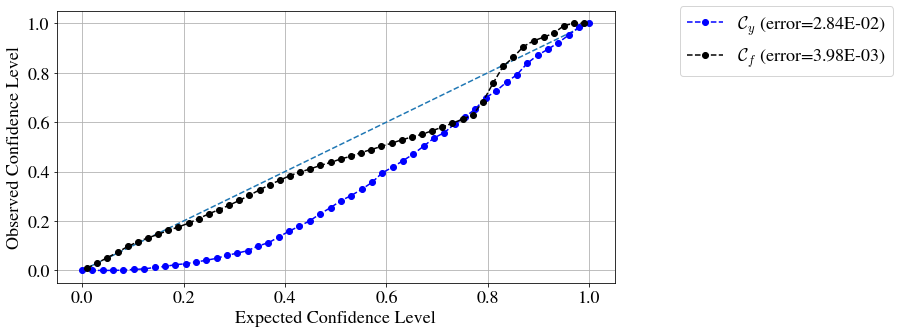

In [30]:
calibration.calibration_global(y_pred,sigma_p,y)
calibration.check_f_calibration(y_pred,sigma_e,f)
plot_predictive(save=True)
plot_calibration(calibration.summary,save=True)